In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm


from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids

# from pomegranate import BayesianNetwork
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import MaximumLikelihoodEstimator

#from sdv.single_table import TVAE, CTGAN
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

In [2]:
# Load NSL-KDD dataset ( Encoded and Important Features only)
data = pd.read_csv('imp_final_df.csv')

# Display the first few rows of the dataset to understand its structure


print('originail shape:', data.shape)

data.head()


originail shape: (125973, 26)


,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,491,0,1.00,0.00,True,25,0.17,0,0.00,0.03,...,0.00,20,150,0.17,False,0.00,2,0.00,False,0
1,146,0,0.08,0.15,True,1,0.00,0,0.00,0.60,...,0.00,15,255,0.88,False,0.00,1,0.00,False,0
2,0,0,0.05,0.07,False,26,0.10,0,1.00,0.05,...,0.00,19,255,0.00,True,0.00,6,0.00,False,1
3,232,8153,1.00,0.00,True,255,1.00,1,0.03,0.00,...,0.04,21,30,0.03,False,0.00,5,0.01,False,0
4,199,420,1.00,0.00,True,255,1.00,1,0.00,0.00,...,0.00,21,255,0.00,False,0.09,32,0.00,False,0


In [3]:
# Split the data into features and target
X = data.drop(columns=['target'])
y = data['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Save the synthetic dataset in a separate dataframe
df_ros = pd.DataFrame(X_ros, columns=X_train.columns)
df_ros['target'] = y_ros
df_ros.to_csv('df_ros.csv', index = False)

# Display the first few rows of the synthetic dataset
print(df_ros.shape)
df_ros.head()


(94280, 26)


,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,0,0,0.01,0.07,False,1,0.00,0,1.0,0.06,...,0.00,19,255,0.00,False,0.0,1,0.0,False,1
1,0,0,0.05,0.07,False,5,0.02,0,1.0,0.07,...,0.00,19,255,0.00,False,0.0,5,0.0,False,1
2,1069,333,1.00,0.00,True,203,1.00,1,0.0,0.00,...,0.01,21,16,0.06,False,1.0,2,0.0,False,0
3,0,0,0.05,0.06,False,10,0.04,0,1.0,0.06,...,0.00,19,255,0.00,False,0.0,10,0.0,False,1
4,0,0,0.08,0.06,False,18,0.07,0,1.0,0.07,...,0.00,18,255,0.00,False,0.0,18,0.0,False,1


In [5]:
# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

df_smote = pd.DataFrame(X_smote, columns=X_train.columns)
df_smote['target'] = y_smote

df_smote.to_csv('df_smote.csv', index = False)

print(df_smote.shape)
df_smote.head()

(94280, 26)


,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,0,0,0.01,0.07,False,1,0.00,0,1.0,0.06,...,0.00,19,255,0.00,False,0.0,1,0.0,False,1
1,0,0,0.05,0.07,False,5,0.02,0,1.0,0.07,...,0.00,19,255,0.00,False,0.0,5,0.0,False,1
2,1069,333,1.00,0.00,True,203,1.00,1,0.0,0.00,...,0.01,21,16,0.06,False,1.0,2,0.0,False,0
3,0,0,0.05,0.06,False,10,0.04,0,1.0,0.06,...,0.00,19,255,0.00,False,0.0,10,0.0,False,1
4,0,0,0.08,0.06,False,18,0.07,0,1.0,0.07,...,0.00,18,255,0.00,False,0.0,18,0.0,False,1


In [6]:
# ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

df_adasyn = pd.DataFrame(X_adasyn, columns=X_train.columns)
df_adasyn['target'] = y_adasyn
df_adasyn.to_csv('df_adasyn.csv', index = False)

print(df_adasyn.shape)
df_adasyn.head()

(94307, 26)


,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,0,0,0.01,0.07,False,1,0.00,0,1.0,0.06,...,0.00,19,255,0.00,False,0.0,1,0.0,False,1
1,0,0,0.05,0.07,False,5,0.02,0,1.0,0.07,...,0.00,19,255,0.00,False,0.0,5,0.0,False,1
2,1069,333,1.00,0.00,True,203,1.00,1,0.0,0.00,...,0.01,21,16,0.06,False,1.0,2,0.0,False,0
3,0,0,0.05,0.06,False,10,0.04,0,1.0,0.06,...,0.00,19,255,0.00,False,0.0,10,0.0,False,1
4,0,0,0.08,0.06,False,18,0.07,0,1.0,0.07,...,0.00,18,255,0.00,False,0.0,18,0.0,False,1


In [7]:
# Cluster Centroids
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X_train, y_train)

df_cc = pd.DataFrame(X_cc, columns=X_train.columns)
df_cc['target'] = y_cc

df_cc.to_csv('df_cc.csv', index = False)

print(df_cc.shape)
df_cc.head()

(82082, 26)


,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,355,2259,1.0,0.0,True,255,1.00,1,0.00,0.00,...,0.04,21,19,0.05,False,0.0,2,0.00,False,0
1,18828976,33116,1.0,0.0,True,24,0.65,1,0.03,0.08,...,0.00,20,37,0.03,False,0.0,1,0.04,False,0
2,2194619,0,1.0,0.0,True,24,0.11,0,0.00,0.05,...,0.08,19,129,0.11,False,0.0,2,0.00,False,0
3,7847476,474404,1.0,0.0,True,3,0.19,0,0.00,0.25,...,0.00,19,16,0.06,False,0.0,1,0.00,False,0
4,0,5129964,1.0,0.0,True,64,0.25,0,0.74,0.02,...,0.00,10,255,0.00,False,0.0,1,0.00,False,0


In [8]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train)
X_gmm, y_gmm = gmm.sample(n_samples=len(X_train))

df_gmm = pd.DataFrame(X_gmm, columns=X_train.columns)
df_gmm['target'] = y_gmm
df_gmm.to_csv('df_gmm.csv', index = False)
print(df_gmm.shape)
df_gmm.head()


(88181, 26)


,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,6.277949e+06,-5.963200e+05,0.982513,0.377671,0.236244,211.607291,0.835286,0.047433,-0.249031,0.201543,...,-0.064482,18.989407,132.775635,-0.142367,0.384112,0.149373,67.704694,0.900969,0.596218,0
1,3.605596e+06,1.960535e+06,0.289925,0.175786,0.429366,65.229741,0.370090,0.868510,0.027331,0.187017,...,-0.064340,20.166234,185.816579,-0.053458,-0.111910,-0.268511,-7.184431,0.510203,-0.267685,0
2,1.202178e+06,1.201176e+06,0.465908,-0.175465,0.654355,85.909978,-0.120776,0.292937,0.462167,0.208116,...,-0.130933,22.174177,288.176391,-0.047498,0.357940,-0.306650,107.818361,0.073878,-0.214275,0
3,8.427646e+06,1.517513e+06,0.605459,-0.096198,0.760634,139.468986,0.527940,0.831543,0.184399,-0.106473,...,-0.095308,21.409496,99.381640,0.144877,0.126716,-0.103875,26.406255,0.109698,0.024644,0
4,5.330828e+06,-2.666064e+06,0.265997,-0.008749,0.068859,-14.961259,0.066528,0.115521,0.557801,0.167436,...,0.149846,19.503996,84.893916,0.122608,0.309729,0.278406,-82.535799,0.506423,-0.076373,0


In [13]:
# Bayesian Network

# Learn the structure of the Bayesian Network
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))

# Create a BayesianNetwork model from the learned structure
bn = BayesianNetwork(best_model.edges())

# After learning the initial structure with HillClimbSearch
all_variables = set(data.columns)
learned_variables = set([var for edge in best_model.edges() for var in edge])

# Identify missing variables
missing_variables = all_variables - learned_variables

# Add missing variables to the model as independent nodes
for variable in missing_variables:
    bn.add_node(variable)

# Now fit the Bayesian Network with all variables included
bn.fit(data, estimator=MaximumLikelihoodEstimator)
# Generating synthetic data
num_samples = data.shape[0]  # Number of synthetic data points to generate
synthetic_data = bn.simulate(num_samples, seed=np.random.seed(42))

# Convert the generated data into a DataFrame
df_bn = pd.DataFrame(synthetic_data)
df_bn.to_csv('df_bn.csv', index = False)
df_bn.head()


Generating for node: srv_diff_host_rate:  73%|███████▎  | 19/26 [00:01<00:00, 16.89it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.
Generating for node: dst_host_same_src_port_rate:  73%|███████▎  | 19/26 [00:01<00:00, 16.89it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
Generating for node: dst_host_srv_diff_host_rate:  81%|████████  | 21/26 [00:01<00:00, 15.64it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
Generating for node: diff_srv_rate: 100%|██████████| 26/26 [00:01<00:00, 16.25it/s]
c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,flag_SF,target,src_bytes,dst_host_diff_srv_rate,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_bytes,service_private,service_domain_u,dst_host_serror_rate,...,logged_in,diff_srv_rate,count,service_http,level,serror_rate,dst_host_srv_diff_host_rate,flag_S0,same_srv_rate,dst_host_srv_rerror_rate
0,True,0,664,0.00,1.00,0.00,138,False,False,0.00,...,0,0.00,1,False,20,0.0,0.00,False,1.00,0.00
1,True,0,35,0.00,1.00,0.01,141,False,True,0.01,...,0,0.00,270,False,18,0.0,0.00,False,1.00,0.00
2,False,0,0,0.00,1.00,1.00,0,False,False,0.00,...,0,0.00,1,True,21,0.0,0.14,False,1.00,0.69
3,False,1,0,0.07,0.08,0.00,0,False,False,1.00,...,0,0.07,205,False,19,1.0,0.00,True,0.02,0.00
4,False,1,0,0.07,0.06,0.00,0,True,False,1.00,...,0,0.07,180,False,21,1.0,0.00,True,0.05,0.00


In [15]:
# TVAE

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['target'])

# Define metadata for the dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)

# TVAE
tvae = TVAESynthesizer(metadata)
tvae.fit(train_data)
synthetic_data = tvae.sample(len(data))
X_tvae = synthetic_data.drop(columns='target').values
y_tvae = synthetic_data['target'].values



df_tvae = pd.DataFrame(X_tvae, columns=X.columns)
df_tvae['target'] = y_tvae

df_tvae.to_csv('df_tvae.csv', index = False)
print(df_tvae.shape)
df_tvae.head()


INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "src_bytes": {
            "sdtype": "numerical"
        },
        "dst_bytes": {
            "sdtype": "numerical"
        },
        "same_srv_rate": {
            "sdtype": "numerical"
        },
        "diff_srv_rate": {
            "sdtype": "numerical"
        },
        "flag_SF": {
            "sdtype": "categorical"
        },
        "dst_host_srv_count": {
            "sdtype": "numerical"
        },
        "dst_host_same_srv_rate": {
            "sdtype": "numerical"
        },
        "logged_in": {
            "sdtype": "categorical"
        },
        "dst_host_serror_rate": {
            "sdtype": "numerical"
        },
        "dst_host_diff_srv_rate": {
            "sdtype": "numerical"
        },
        "dst_host_srv_serror_rate": {
            "sdtype": "numerical"
        },
        "serror_rate": {
        

(125973, 26)


,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,118,0,0.06,0.08,False,7,0.04,0,1.0,0.07,...,0.0,20,255,0.0,False,0.0,24,1.0,False,1
1,881,3446,1.0,0.0,False,17,1.0,0,0.0,0.99,...,0.97,12,14,0.03,False,0.0,1,1.0,False,1
2,0,0,1.0,0.0,False,2,0.0,0,0.0,0.97,...,1.0,20,20,0.04,False,0.0,1,1.0,False,0
3,216,0,0.23,0.44,True,5,0.02,0,0.0,0.07,...,0.0,18,55,0.24,True,0.0,5,0.0,False,0
4,0,0,1.0,0.0,True,66,0.26,1,0.0,0.07,...,0.0,18,196,0.01,False,0.0,1,0.0,False,0


In [16]:
# CTGAN

# Define metadata for the dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)


# CTGAN
ctgan = CTGANSynthesizer(metadata)
ctgan.fit(train_data)

synthetic_data = ctgan.sample(len(data))
X_ctgan = synthetic_data.drop(columns='target').values
y_ctgan = synthetic_data['target'].values

df_ctgan = pd.DataFrame(X_ctgan, columns=X_train.columns)
df_ctgan['target'] = y_ctgan
df_ctgan.to_csv('df_ctgan.csv', index = False)

df_ctgan.head()


INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "src_bytes": {
            "sdtype": "numerical"
        },
        "dst_bytes": {
            "sdtype": "numerical"
        },
        "same_srv_rate": {
            "sdtype": "numerical"
        },
        "diff_srv_rate": {
            "sdtype": "numerical"
        },
        "flag_SF": {
            "sdtype": "categorical"
        },
        "dst_host_srv_count": {
            "sdtype": "numerical"
        },
        "dst_host_same_srv_rate": {
            "sdtype": "numerical"
        },
        "logged_in": {
            "sdtype": "categorical"
        },
        "dst_host_serror_rate": {
            "sdtype": "numerical"
        },
        "dst_host_diff_srv_rate": {
            "sdtype": "numerical"
        },
        "dst_host_srv_serror_rate": {
            "sdtype": "numerical"
        },
        "serror_rate": {
        

,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,flag_SF,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_serror_rate,dst_host_diff_srv_rate,...,dst_host_srv_diff_host_rate,level,dst_host_count,dst_host_same_src_port_rate,service_private,srv_diff_host_rate,srv_count,dst_host_srv_rerror_rate,service_domain_u,target
0,0,0,0.14,0.06,False,14,0.06,0,1.0,0.09,...,0.0,21,255,0.0,True,0.0,17,0.0,False,1
1,9680,9139,1.0,0.0,True,255,1.0,1,0.0,0.0,...,0.04,21,74,0.04,False,0.16,14,0.0,False,0
2,1443,1032,1.0,0.0,True,255,1.0,1,0.0,0.0,...,0.02,21,23,0.02,False,0.0,5,0.0,False,0
3,6650,0,0.19,0.07,False,14,0.04,0,0.0,0.18,...,0.0,20,255,0.03,True,0.0,12,1.0,False,1
4,0,0,1.0,0.0,True,255,1.0,1,0.0,0.0,...,0.02,21,26,0.03,False,0.0,2,0.0,False,0


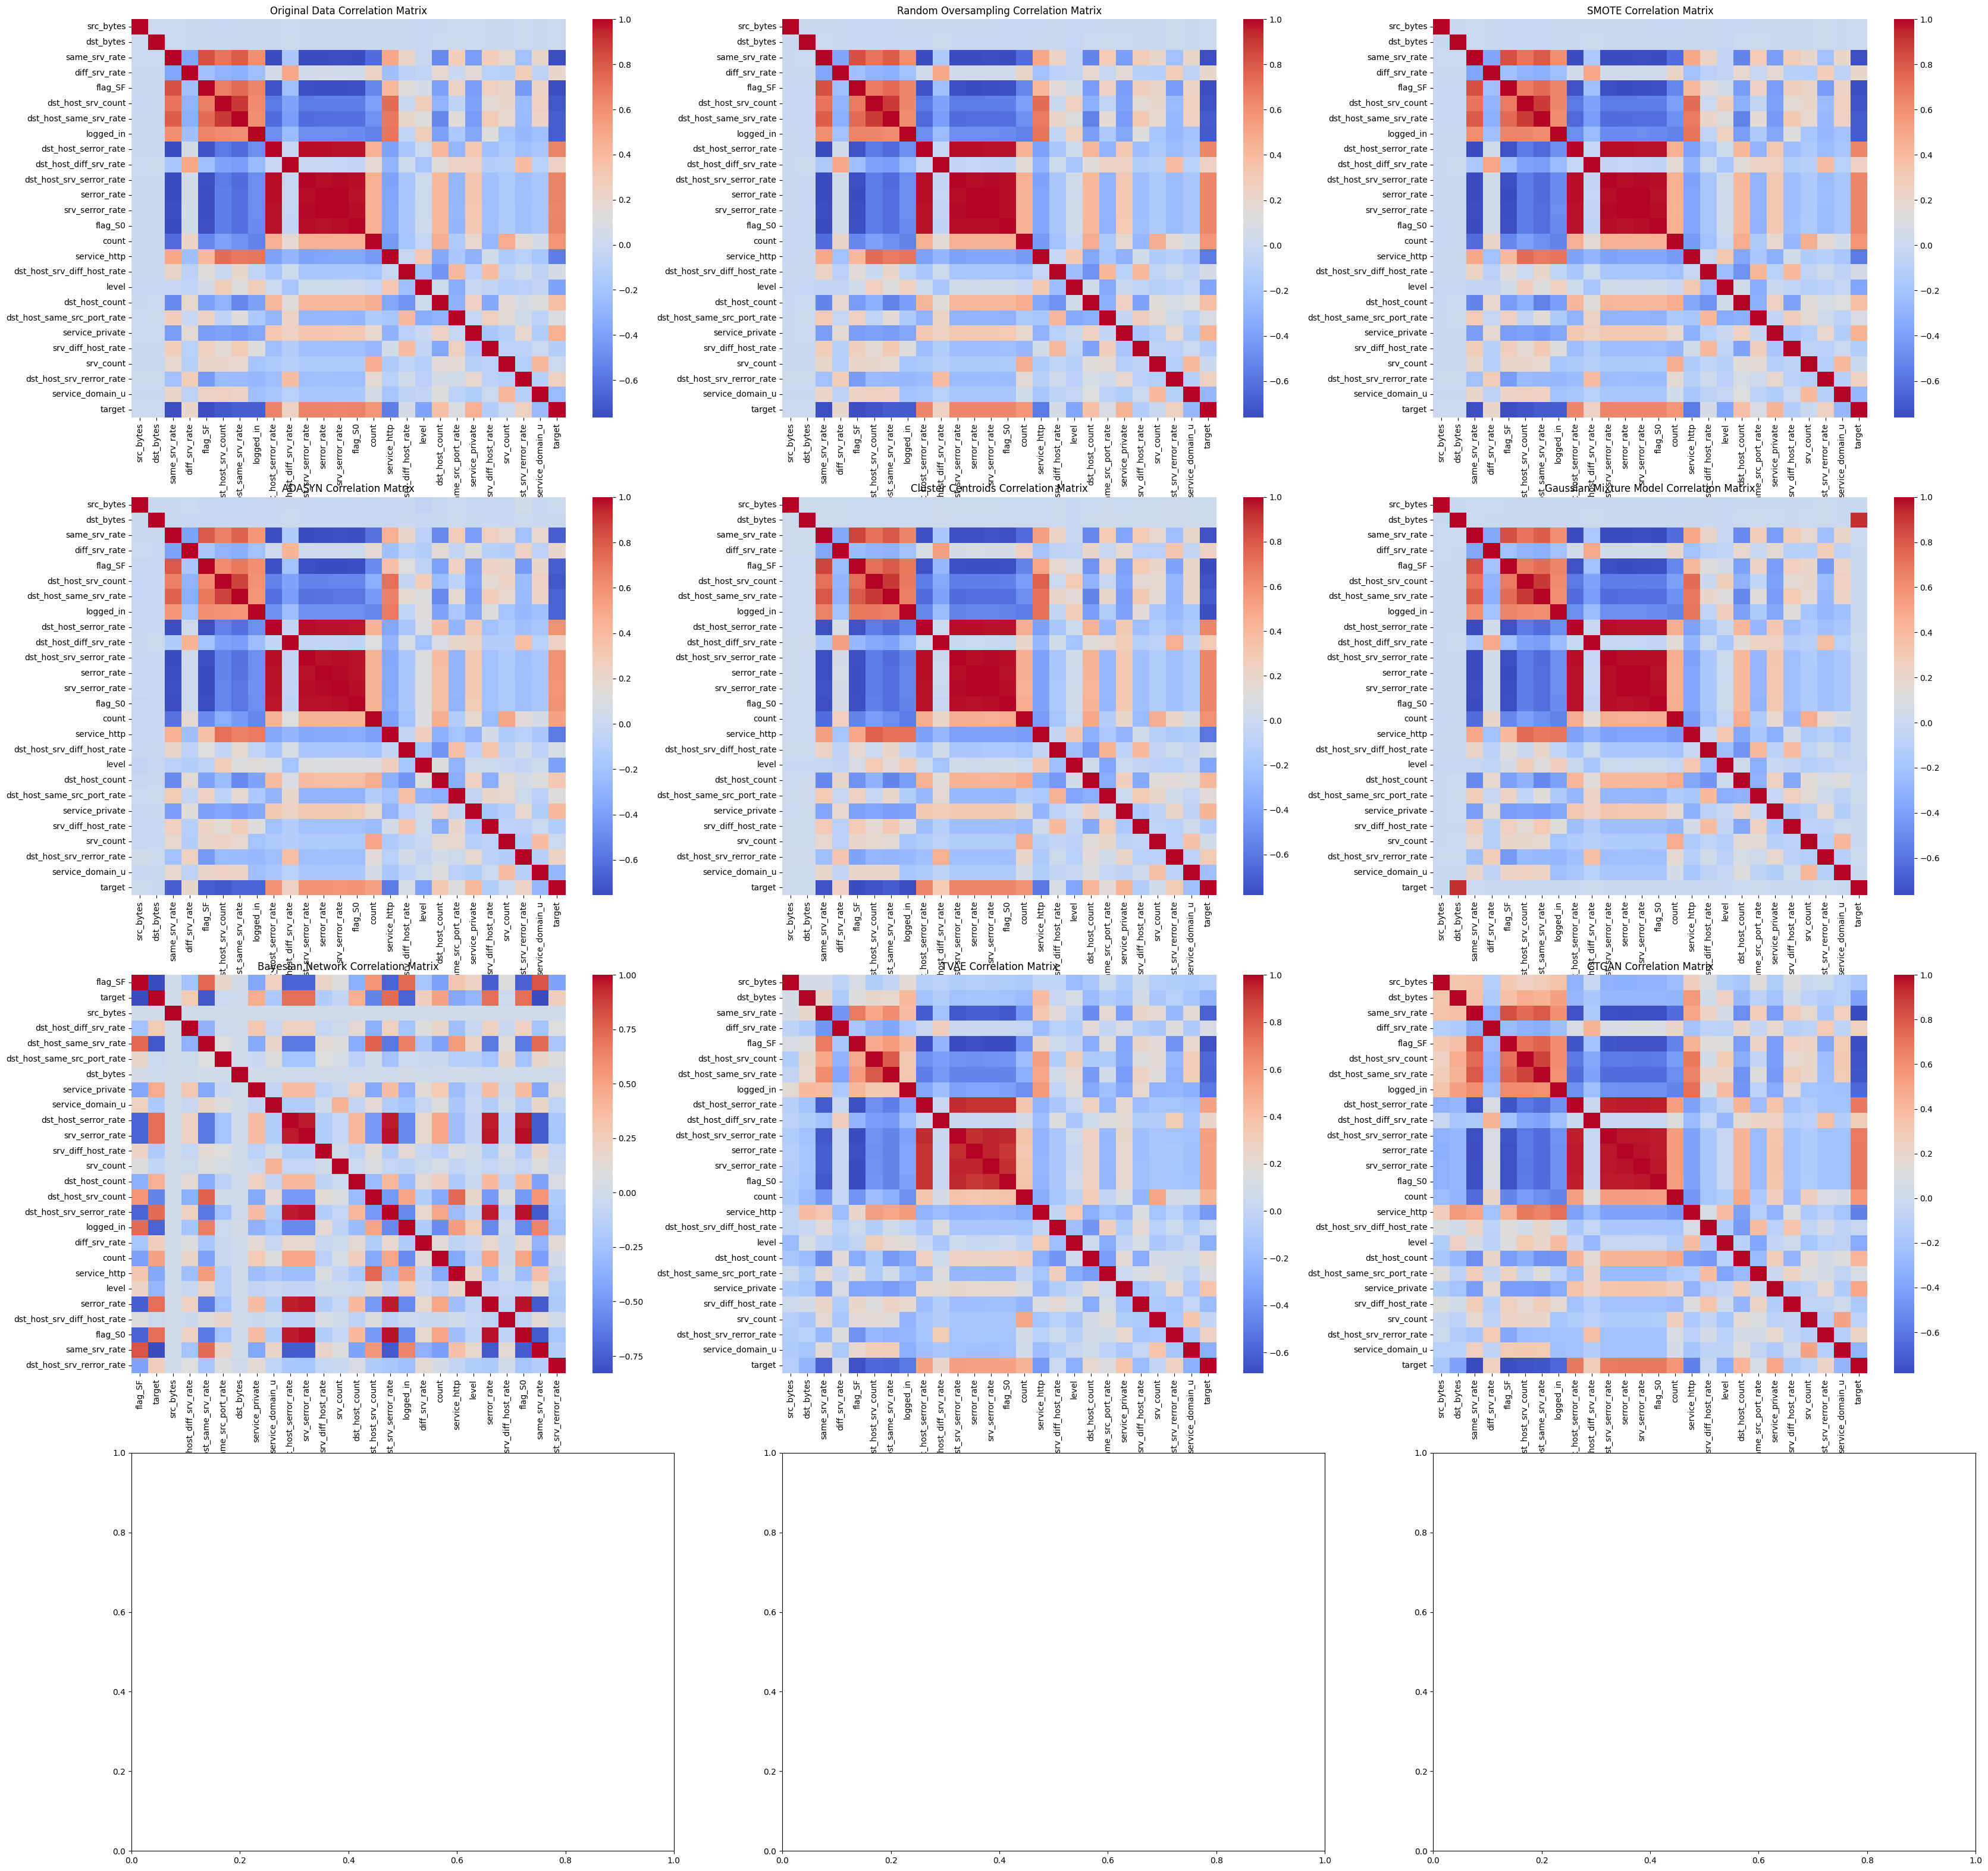

In [17]:
# Plot the correlation matrix of the original and all oversampled data
fig, axes = plt.subplots(4, 3, figsize=(40, 40))
sns.heatmap(data.corr(), ax=axes[0, 0], cmap="coolwarm", annot=False, xticklabels=data.corr().columns, yticklabels=data.corr().columns)
axes[0, 0].set_title("Original Data Correlation Matrix")
sns.heatmap(df_ros.corr(), ax=axes[0, 1], cmap="coolwarm", annot=False, xticklabels=df_ros.corr().columns, yticklabels=df_ros.corr().columns)
axes[0, 1].set_title("Random Oversampling Correlation Matrix")
sns.heatmap(df_smote.corr(), ax=axes[0, 2], cmap="coolwarm", annot=False, xticklabels=df_smote.corr().columns, yticklabels=df_smote.corr().columns)
axes[0, 2].set_title("SMOTE Correlation Matrix")
sns.heatmap(df_adasyn.corr(), ax=axes[1, 0], cmap="coolwarm", annot=False, xticklabels=df_adasyn.corr().columns, yticklabels=df_adasyn.corr().columns)
axes[1, 0].set_title("ADASYN Correlation Matrix")
sns.heatmap(df_cc.corr(), ax=axes[1, 1], cmap="coolwarm", annot=False, xticklabels=df_cc.corr().columns, yticklabels=df_cc.corr().columns)
axes[1, 1].set_title("Cluster Centroids Correlation Matrix")
sns.heatmap(df_gmm.corr(), ax=axes[1, 2], cmap="coolwarm", annot=False, xticklabels=df_gmm.corr().columns, yticklabels=df_gmm.corr().columns)
axes[1, 2].set_title("Gaussian Mixture Model Correlation Matrix")
sns.heatmap(df_bn.corr(), ax=axes[2, 0], cmap="coolwarm", annot=False, xticklabels=df_bn.corr().columns, yticklabels=df_bn.corr().columns)
axes[2, 0].set_title("Bayesian Network Correlation Matrix")
sns.heatmap(df_tvae.corr(), ax=axes[2, 1], cmap="coolwarm", annot=False, xticklabels=df_tvae.corr().columns, yticklabels=df_tvae.corr().columns)
axes[2, 1].set_title("TVAE Correlation Matrix")
sns.heatmap(df_ctgan.corr(), ax=axes[2, 2], cmap="coolwarm", annot=False, xticklabels=df_ctgan.corr().columns, yticklabels=df_ctgan.corr().columns)
axes[2, 2].set_title("CTGAN Correlation Matrix")
# sns.heatmap(df_ddmp.corr(), ax=axes[3, 0], cmap="coolwarm", annot=False, xticklabels=df_ddmp.corr().columns, yticklabels=df_ddmp.corr().columns)
# axes[3, 0].set_title("TABDDMP Correlation Matrix")
plt.show()

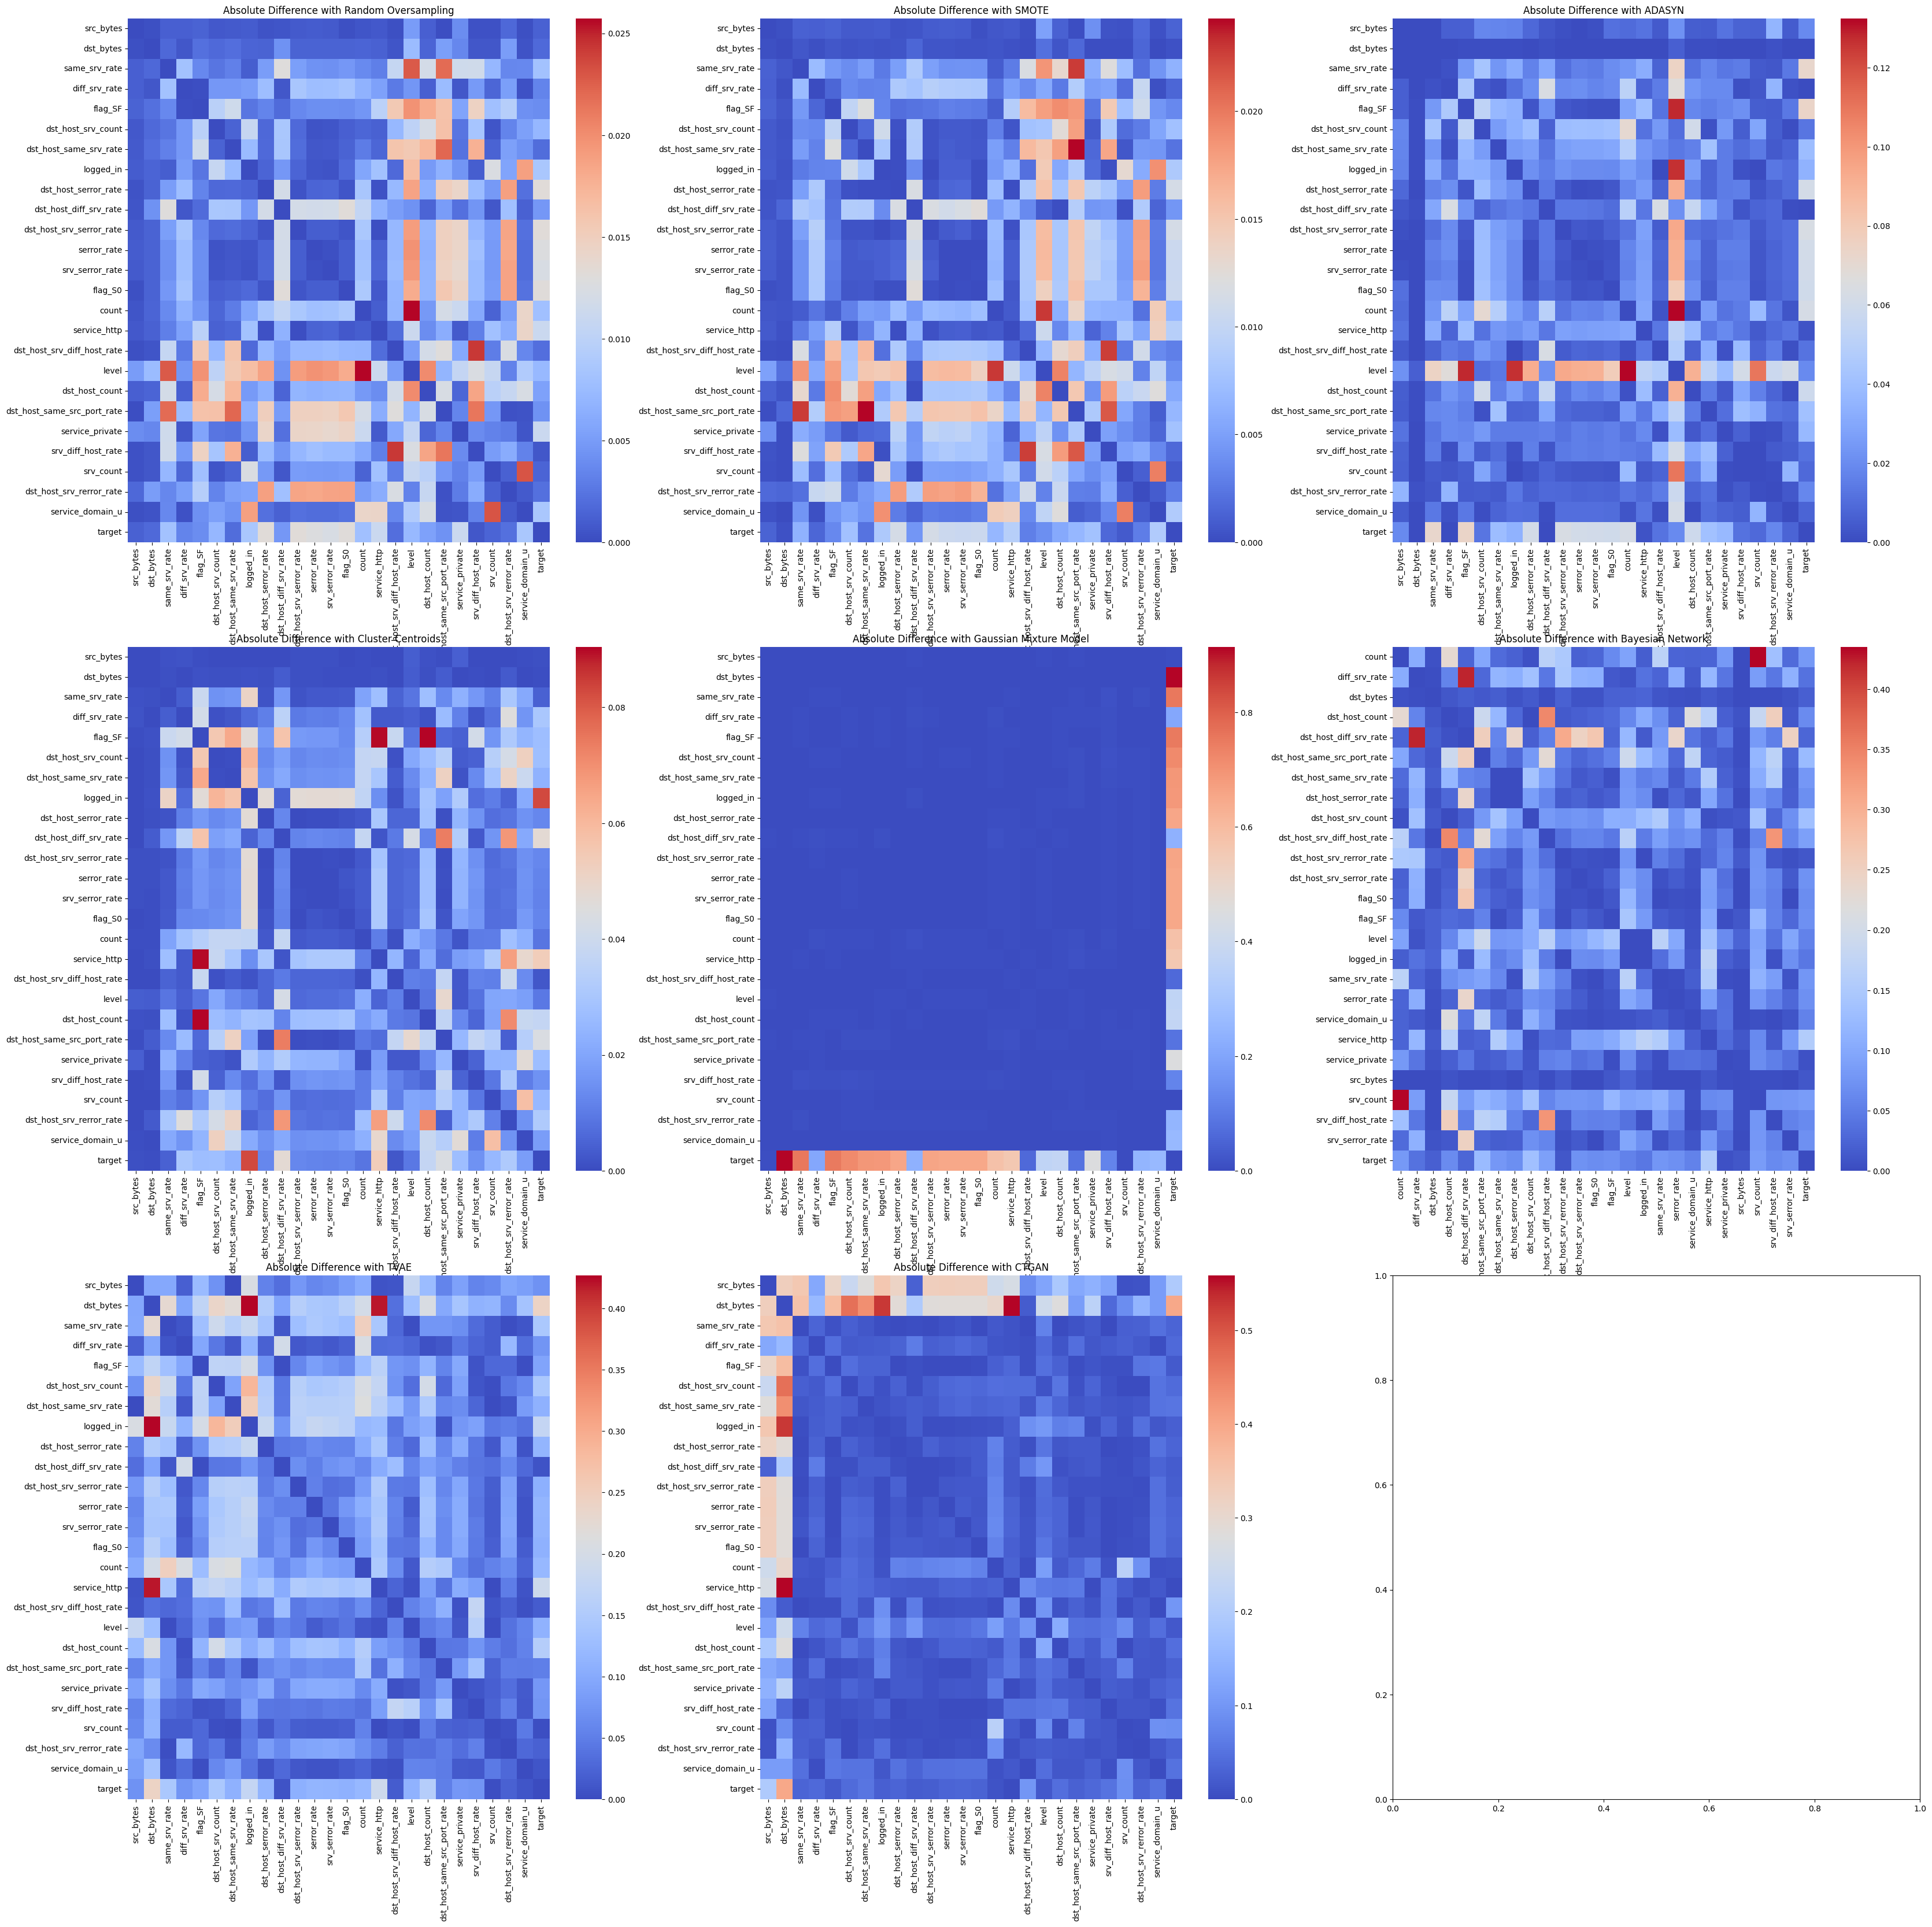

In [18]:
# Calculate the correlation matrices for the original and synthetic datasets
corr_original = data.corr()
corr_ros = df_ros.corr()
corr_smote = df_smote.corr()
corr_adasyn = df_adasyn.corr()
corr_cc = df_cc.corr()
corr_gmm = df_gmm.corr()
corr_bn = df_bn.corr()
corr_tvae = df_tvae.corr()
corr_ctgan = df_ctgan.corr()
# corr_ddmp = df_ddmp.corr()

# Calculate the absolute difference matrices
abs_diff_ros = np.abs(corr_original - corr_ros)
abs_diff_smote = np.abs(corr_original - corr_smote)
abs_diff_adasyn = np.abs(corr_original - corr_adasyn)
abs_diff_cc = np.abs(corr_original - corr_cc)
abs_diff_gmm = np.abs(corr_original - corr_gmm)
abs_diff_bn = np.abs(corr_original - corr_bn)
abs_diff_tvae = np.abs(corr_original - corr_tvae)
abs_diff_ctgan = np.abs(corr_original - corr_ctgan)
# abs_diff_ddmp = np.abs(corr_original - corr_ddmp)

# Plot the absolute difference heatmaps
fig, axes = plt.subplots(3, 3, figsize=(40, 40))
sns.heatmap(abs_diff_ros, ax=axes[0, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_ros.columns, yticklabels=abs_diff_ros.columns)
axes[0, 0].set_title("Absolute Difference with Random Oversampling")
sns.heatmap(abs_diff_smote, ax=axes[0, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_smote.columns, yticklabels=abs_diff_smote.columns)
axes[0, 1].set_title("Absolute Difference with SMOTE")
sns.heatmap(abs_diff_adasyn, ax=axes[0, 2], cmap="coolwarm", annot=False, xticklabels=abs_diff_adasyn.columns, yticklabels=abs_diff_adasyn.columns)
axes[0, 2].set_title("Absolute Difference with ADASYN")
sns.heatmap(abs_diff_cc, ax=axes[1, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_cc.columns, yticklabels=abs_diff_cc.columns)
axes[1, 0].set_title("Absolute Difference with Cluster Centroids")
sns.heatmap(abs_diff_gmm, ax=axes[1, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_gmm.columns, yticklabels=abs_diff_gmm.columns)
axes[1, 1].set_title("Absolute Difference with Gaussian Mixture Model")
sns.heatmap(abs_diff_bn, ax=axes[1, 2], cmap="coolwarm", annot=False, xticklabels=abs_diff_bn.columns, yticklabels=abs_diff_bn.columns)
axes[1, 2].set_title("Absolute Difference with Bayesian Network")
sns.heatmap(abs_diff_tvae, ax=axes[2, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_tvae.columns, yticklabels=abs_diff_tvae.columns)
axes[2, 0].set_title("Absolute Difference with TVAE")
sns.heatmap(abs_diff_ctgan, ax=axes[2, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_ctgan.columns, yticklabels=abs_diff_ctgan.columns)
axes[2, 1].set_title("Absolute Difference with CTGAN")
# sns.heatmap(abs_diff_ddmp, ax=axes[2, 2], cmap="coolwarm", annot=False, xticklabels=abs_diff_ddmp.columns, yticklabels=abs_diff_ddmp.columns)
# axes[2, 2].set_title("Absolute Difference with TABDDMP")
plt.show()



--- Average Results ---
Original Data:
Equal Distributions: 25
Different Distributions: 0
Average KS P-value: 1.0
-----------------------------
Random Oversampling:
Equal Distributions: 2
Different Distributions: 23
Average KS P-value: 0.010470790806450992
-----------------------------
SMOTE:
Equal Distributions: 2
Different Distributions: 23
Average KS P-value: 0.011438567875305828
-----------------------------
ADASYN:
Equal Distributions: 3
Different Distributions: 22
Average KS P-value: 0.03160844466120584
-----------------------------
Cluster Centroids:
Equal Distributions: 1
Different Distributions: 24
Average KS P-value: 0.01200926421621593
-----------------------------
Gaussian Mixture Model:
Equal Distributions: 0
Different Distributions: 25
Average KS P-value: 0.0
-----------------------------
Bayesian Network:
Equal Distributions: 9
Different Distributions: 16
Average KS P-value: 0.19999841832380064
-----------------------------
TVAE:
Equal Distributions: 0
Different Distrib

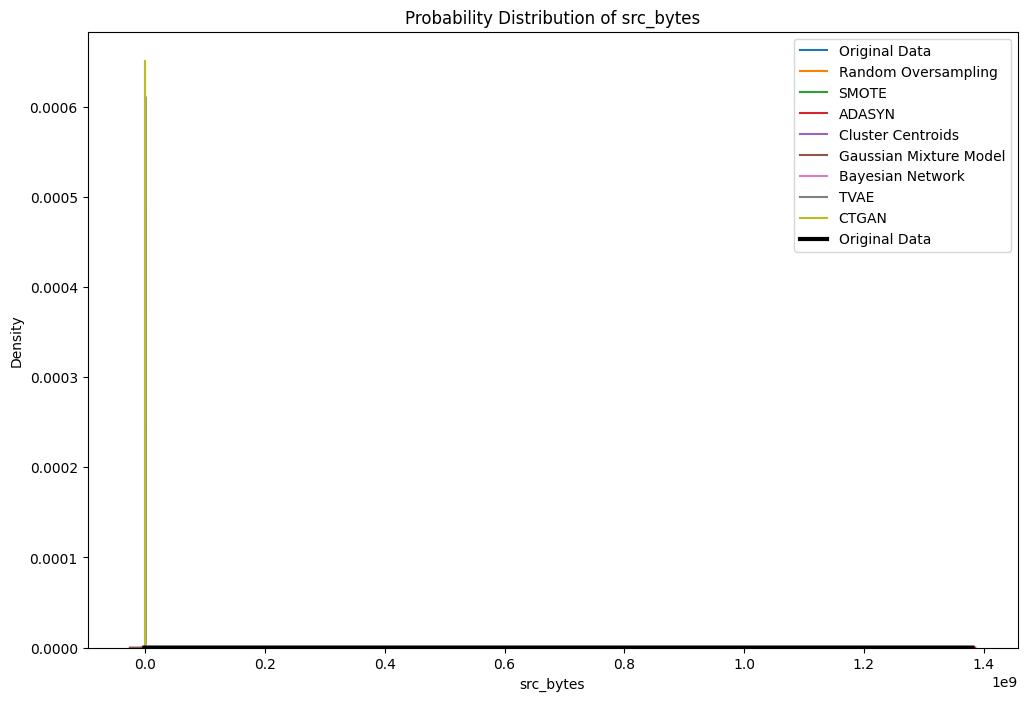

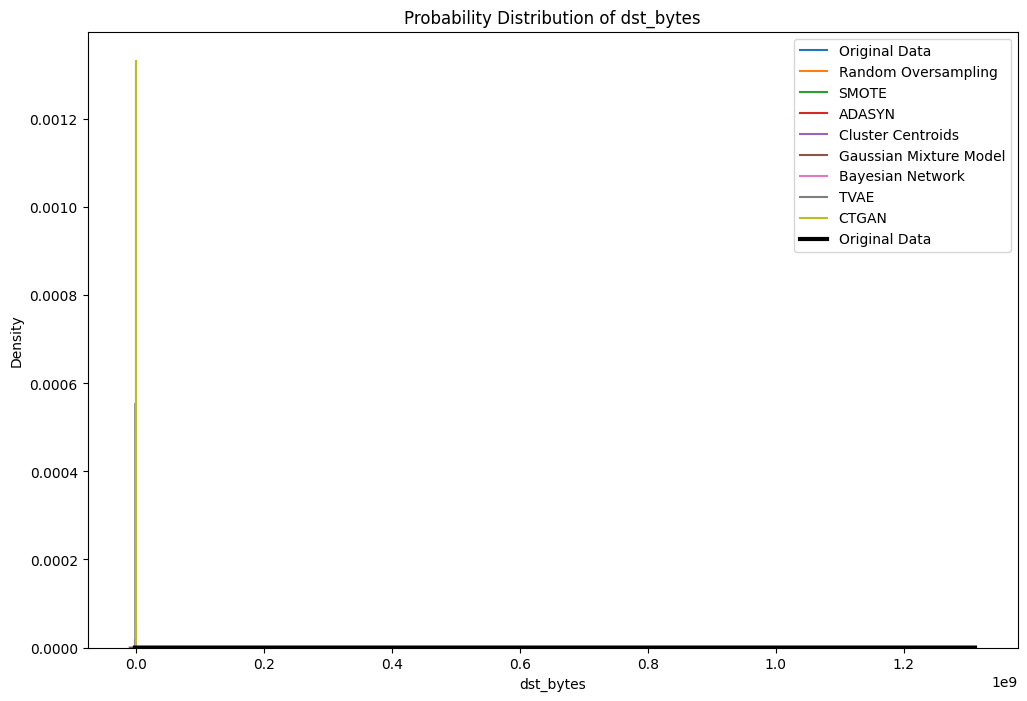

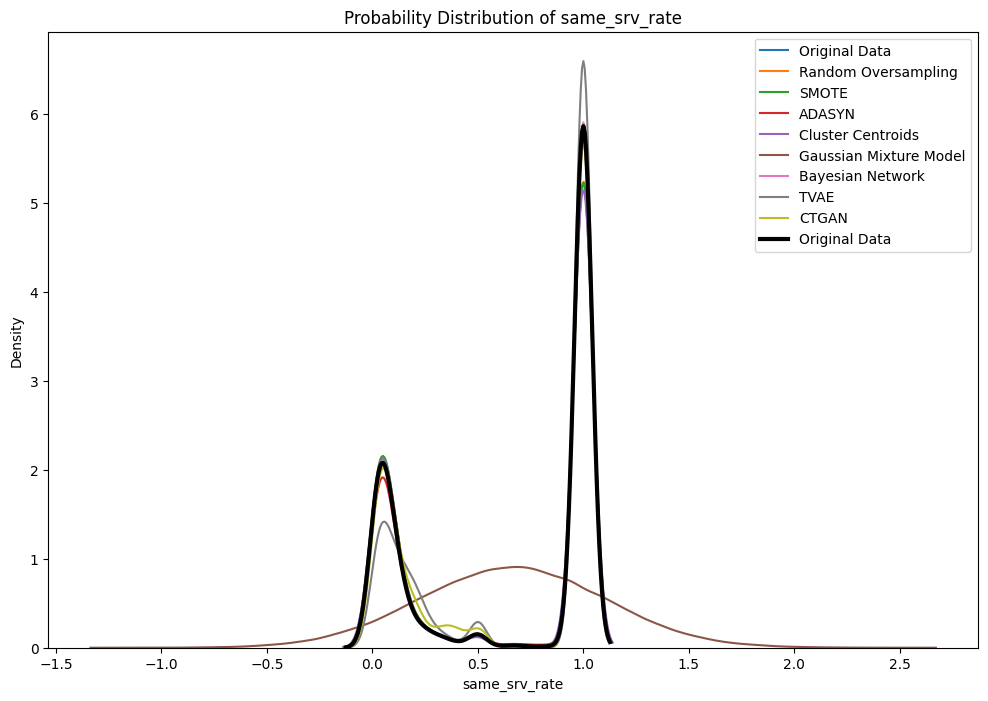

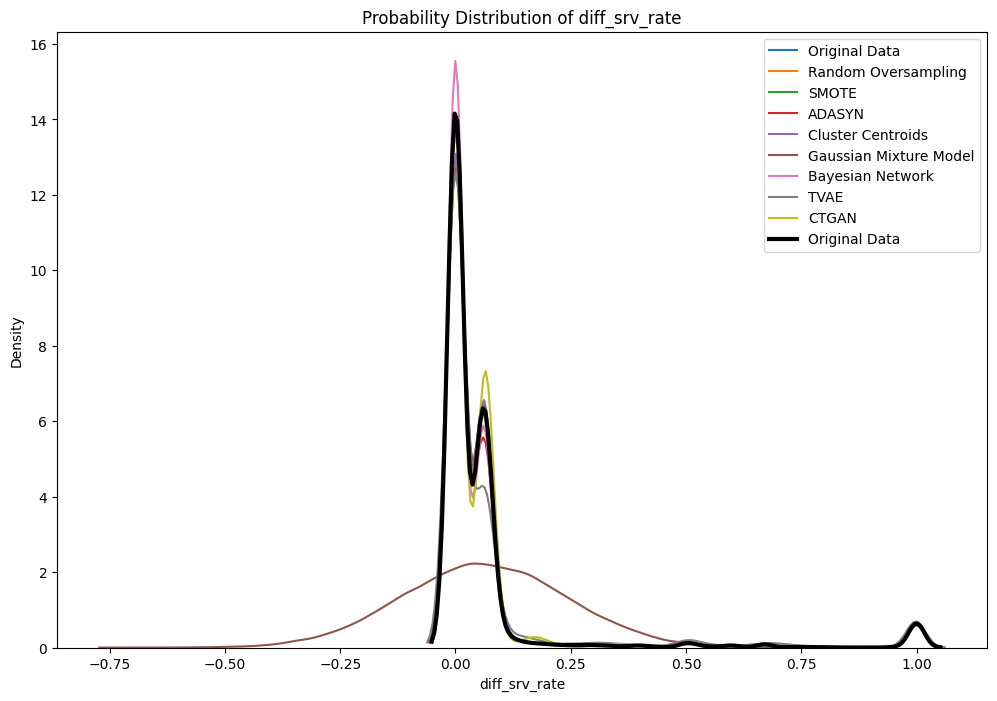

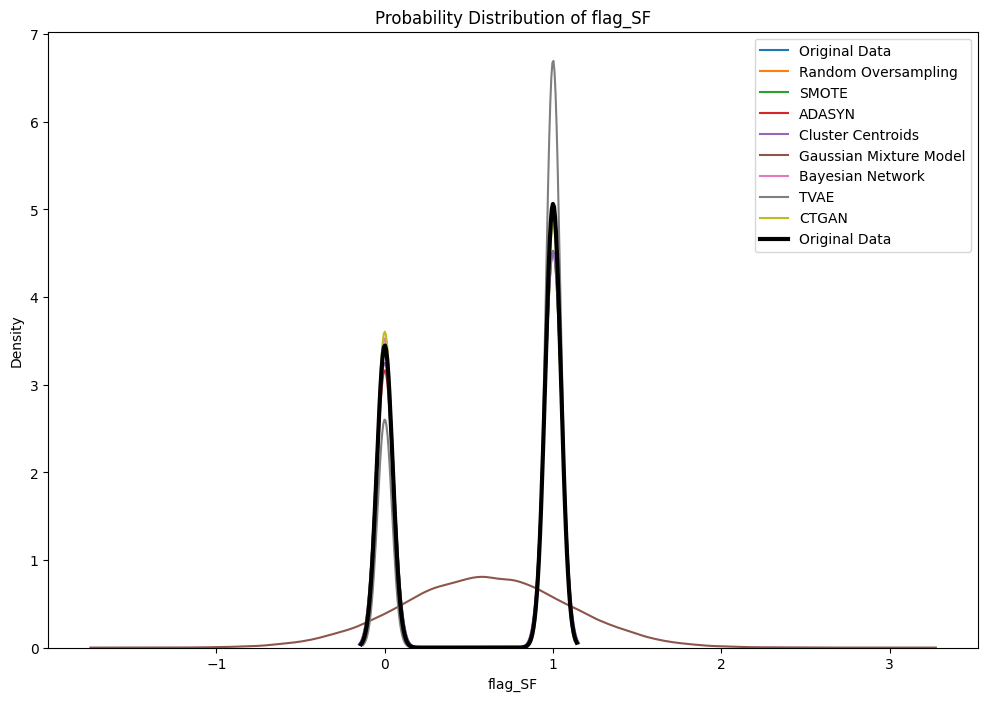

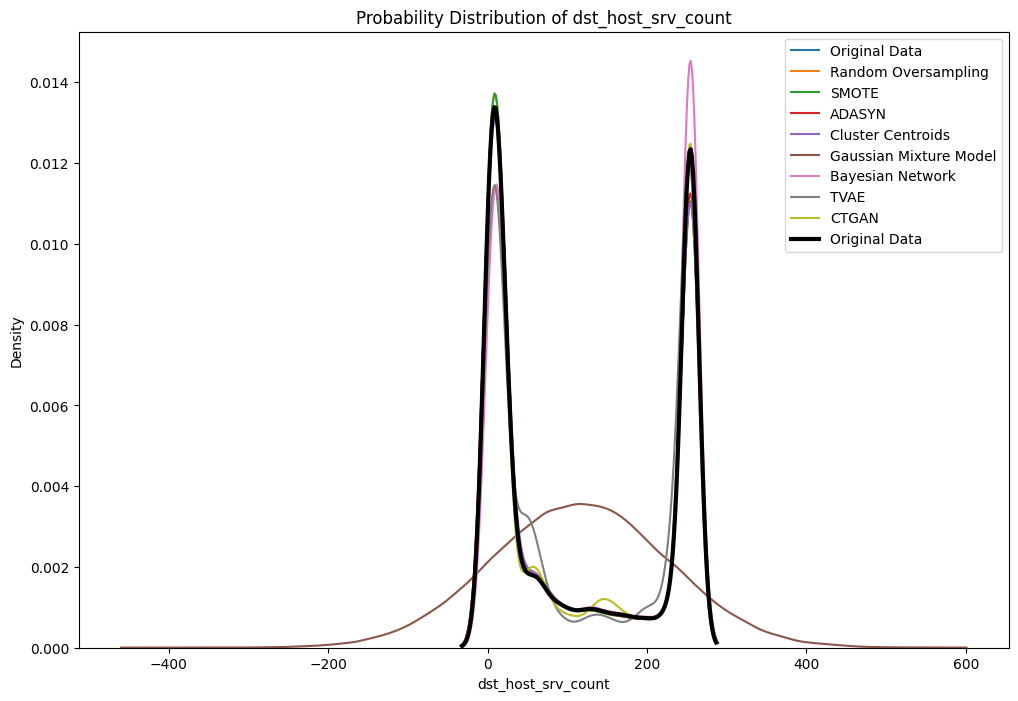

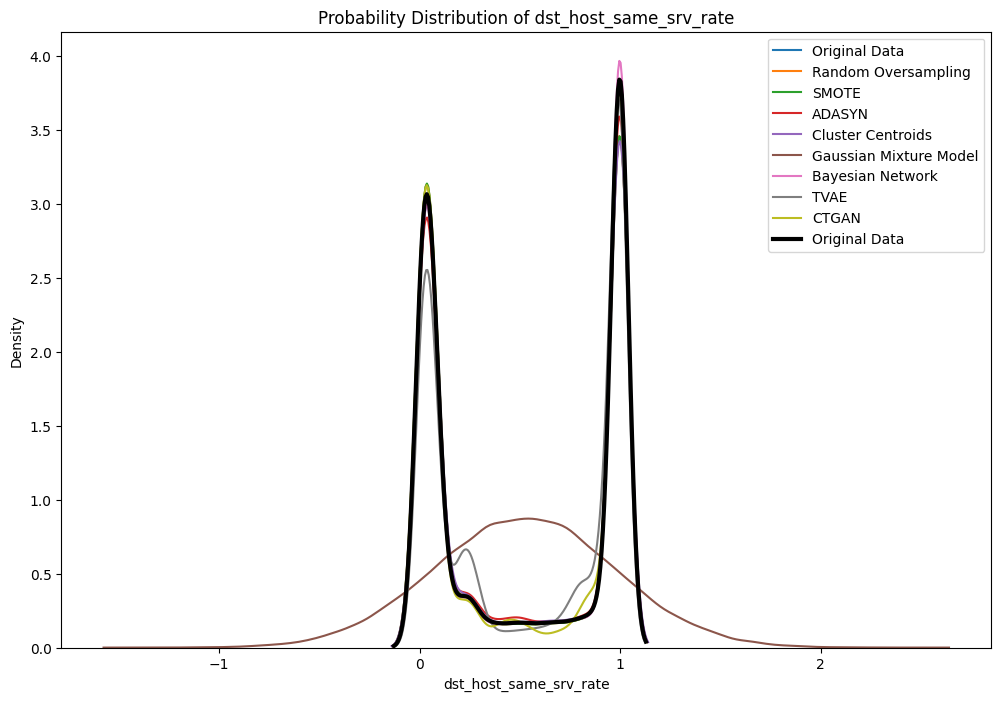

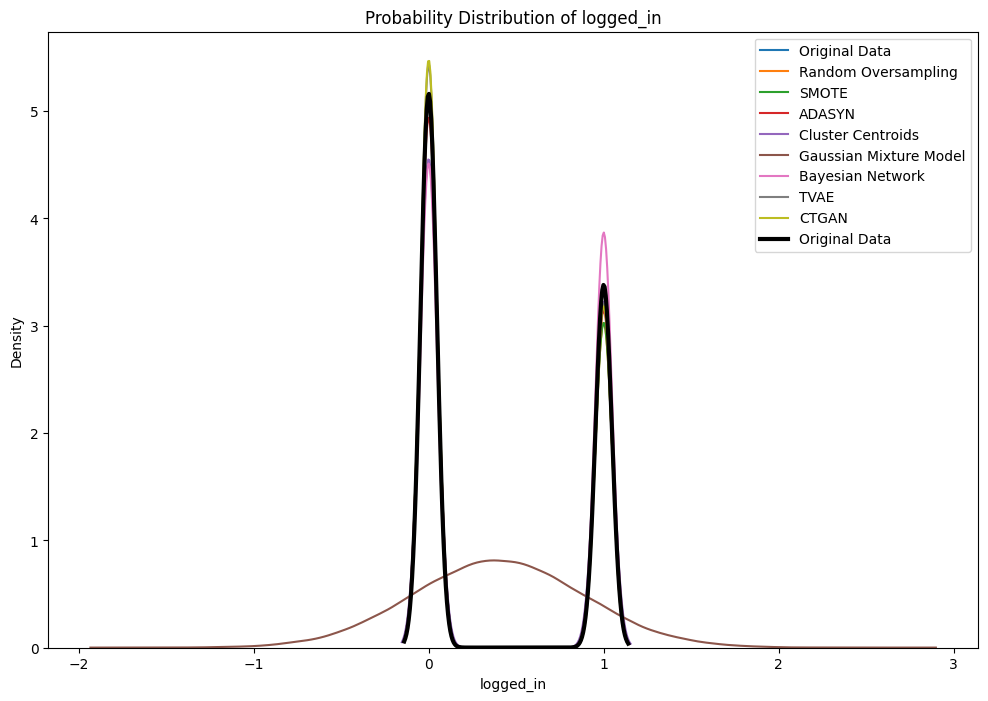

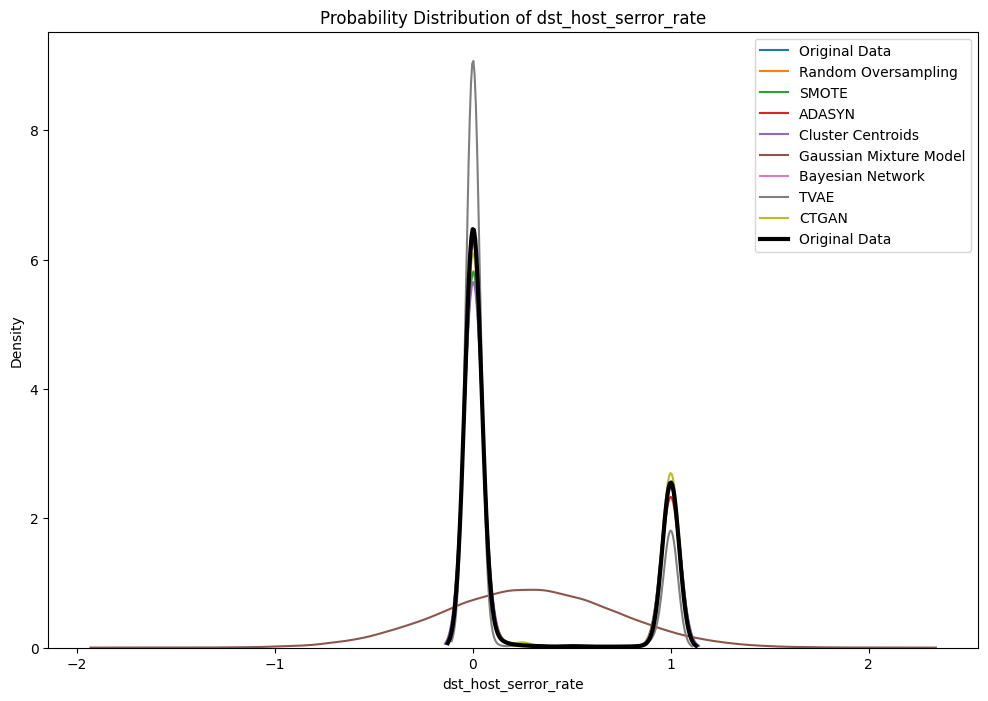

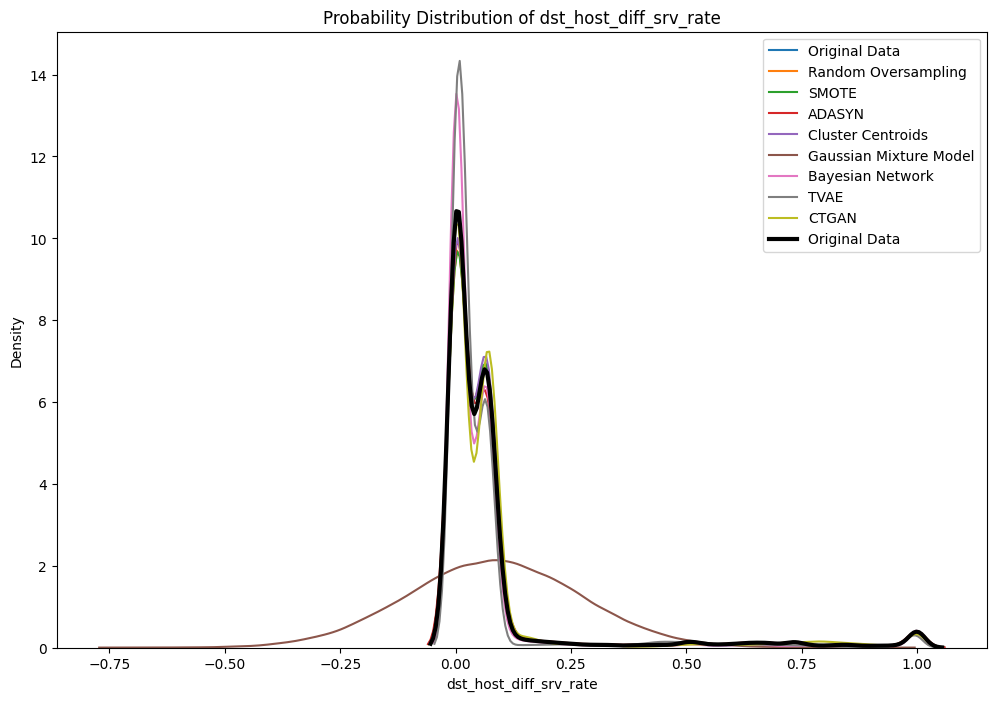

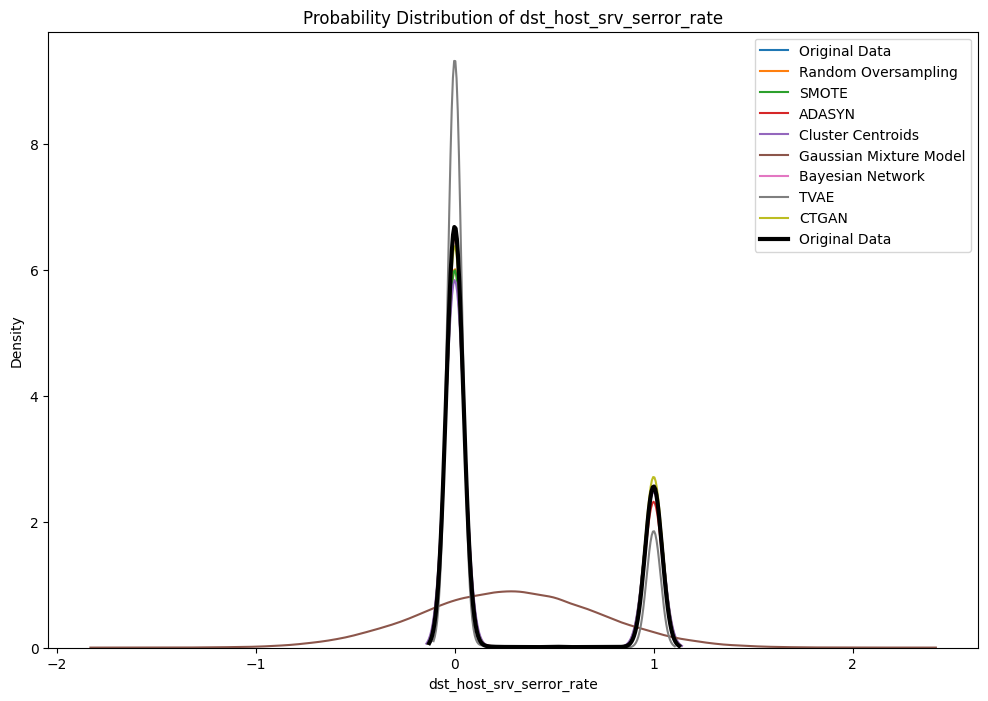

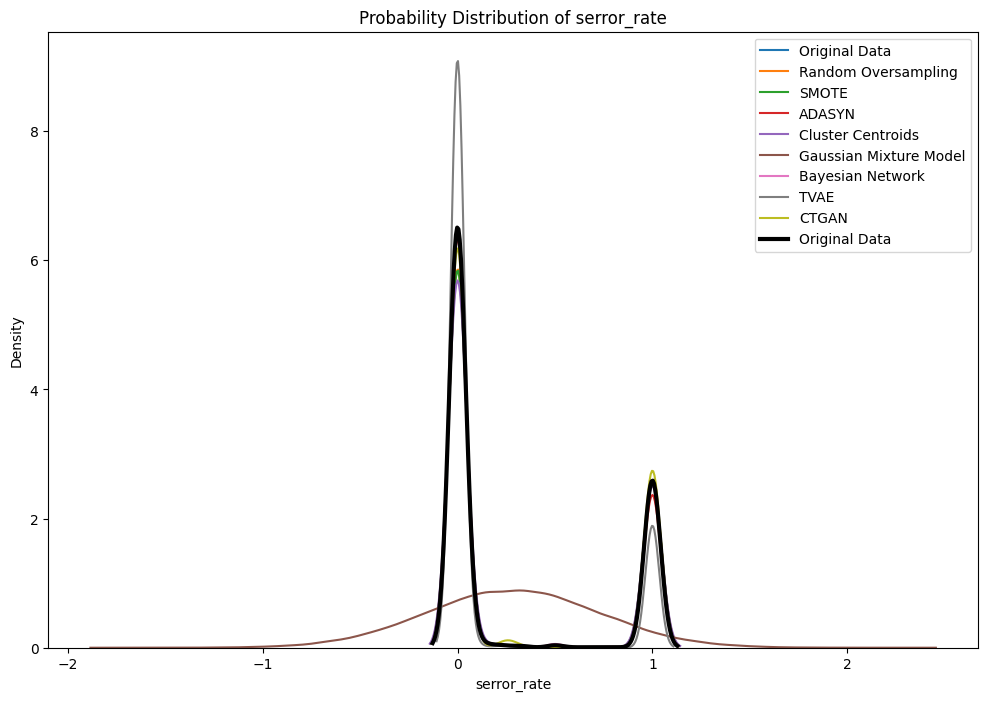

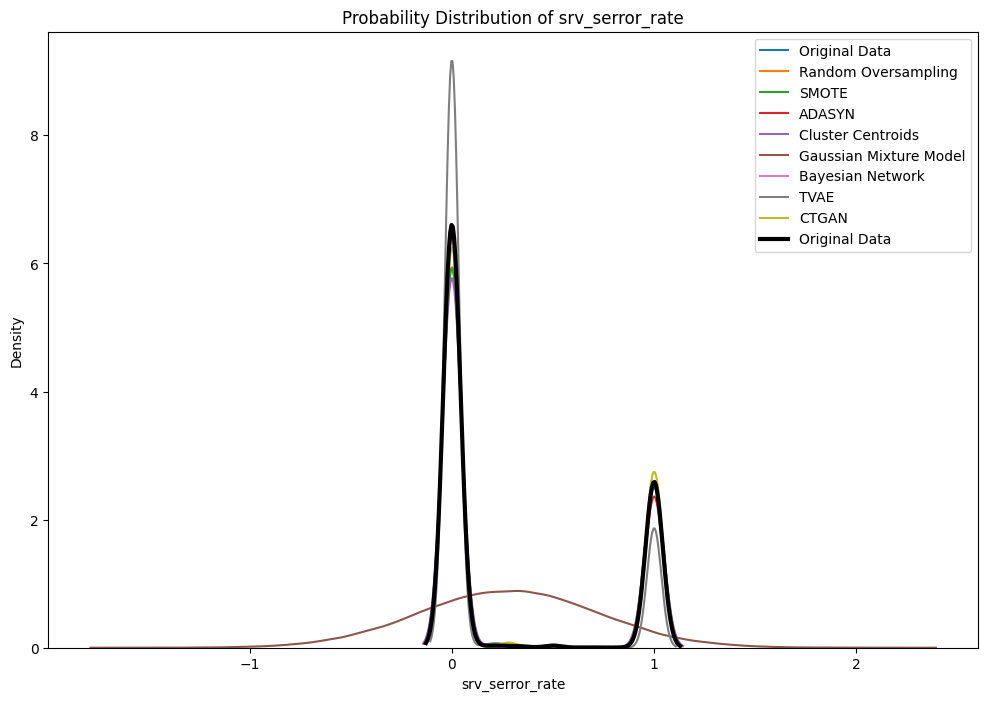

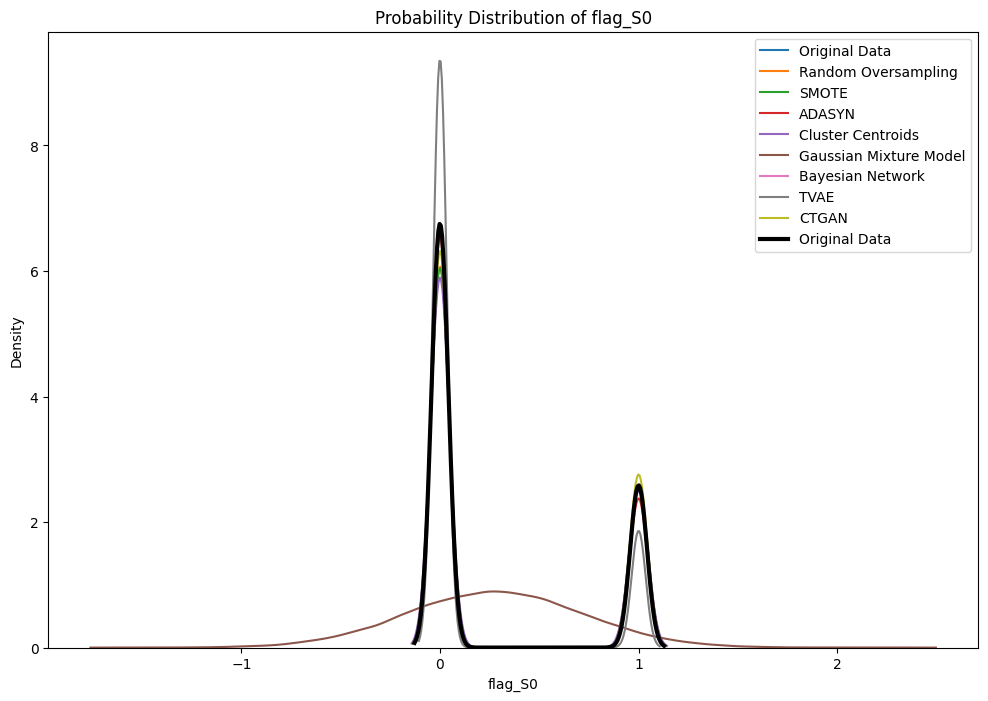

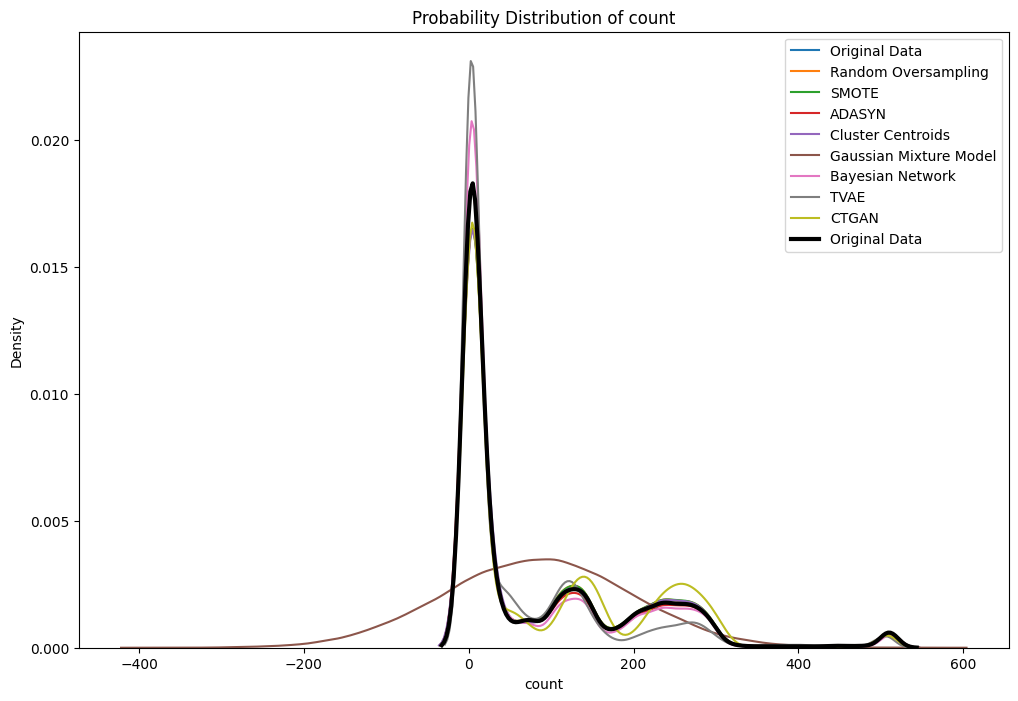

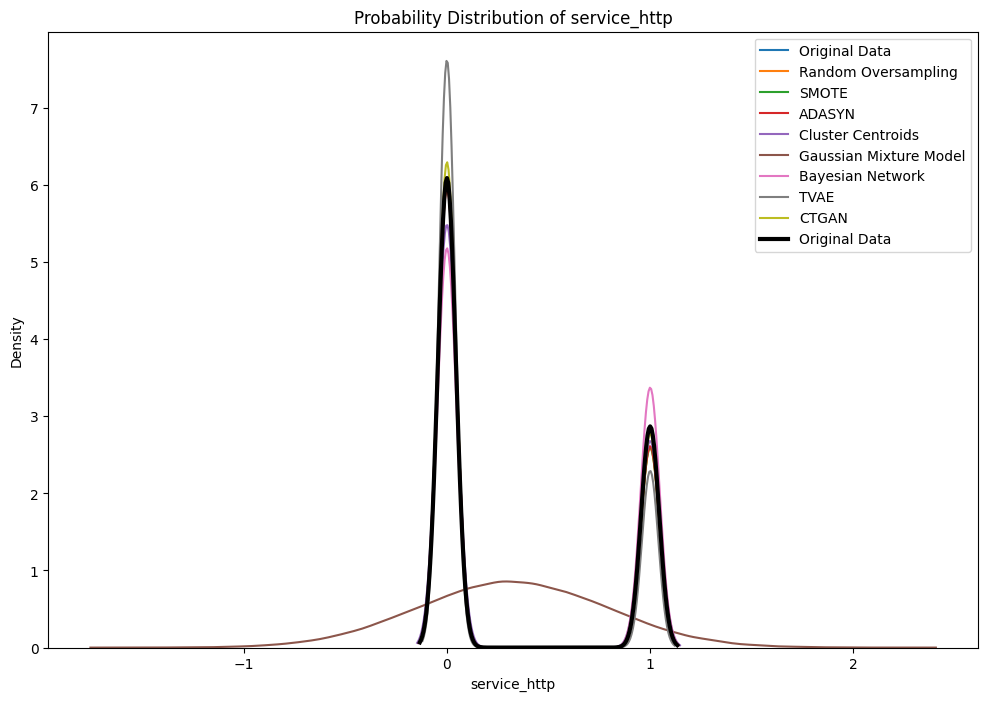

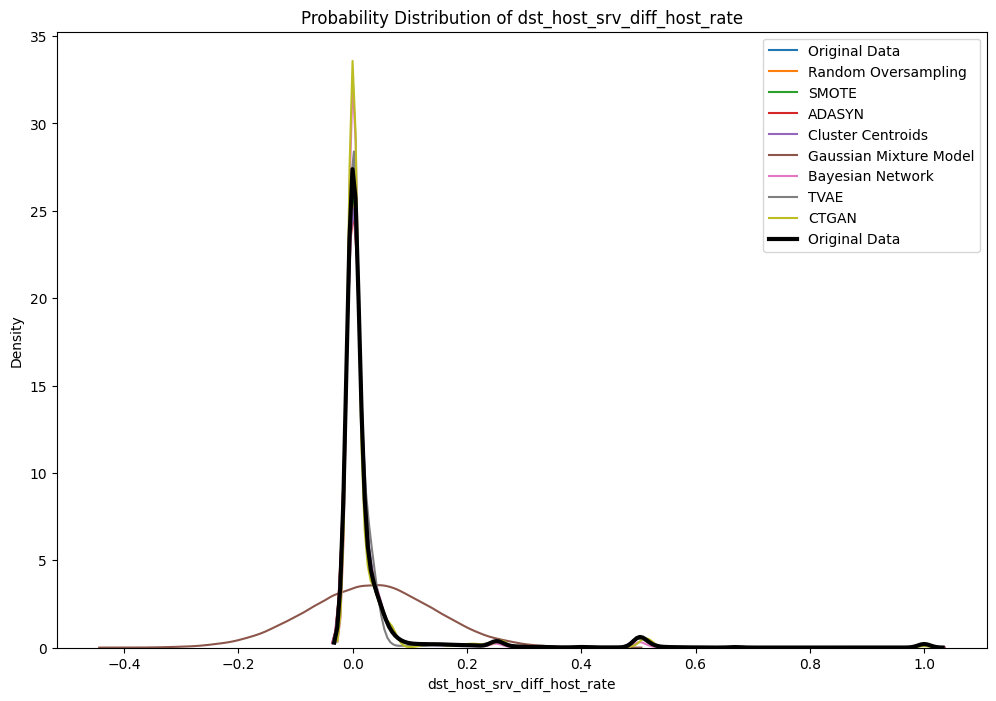

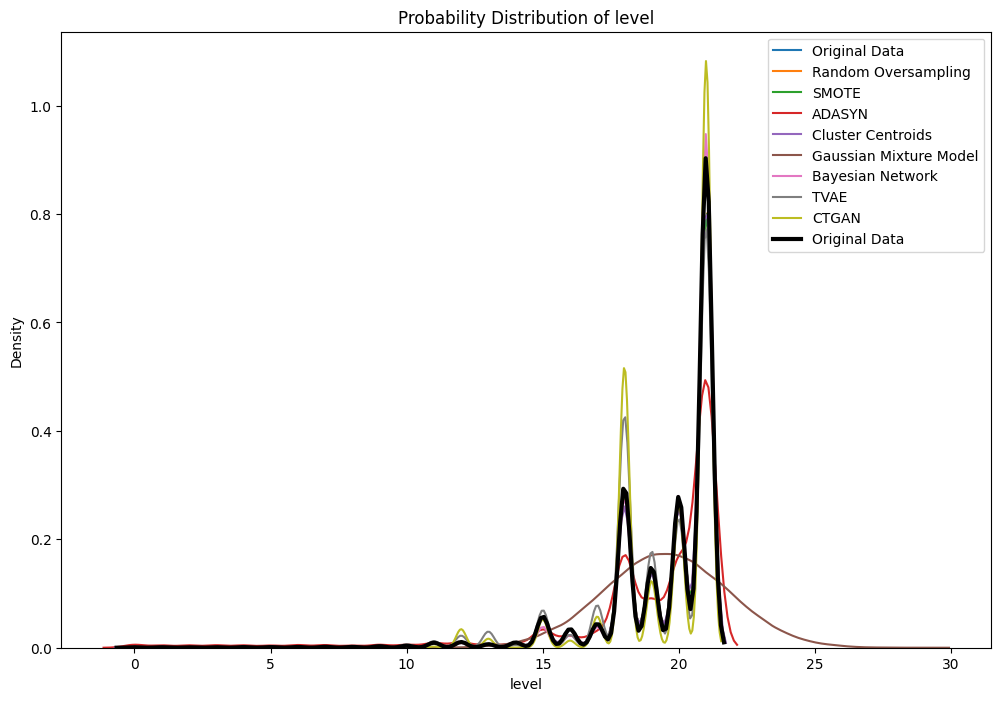

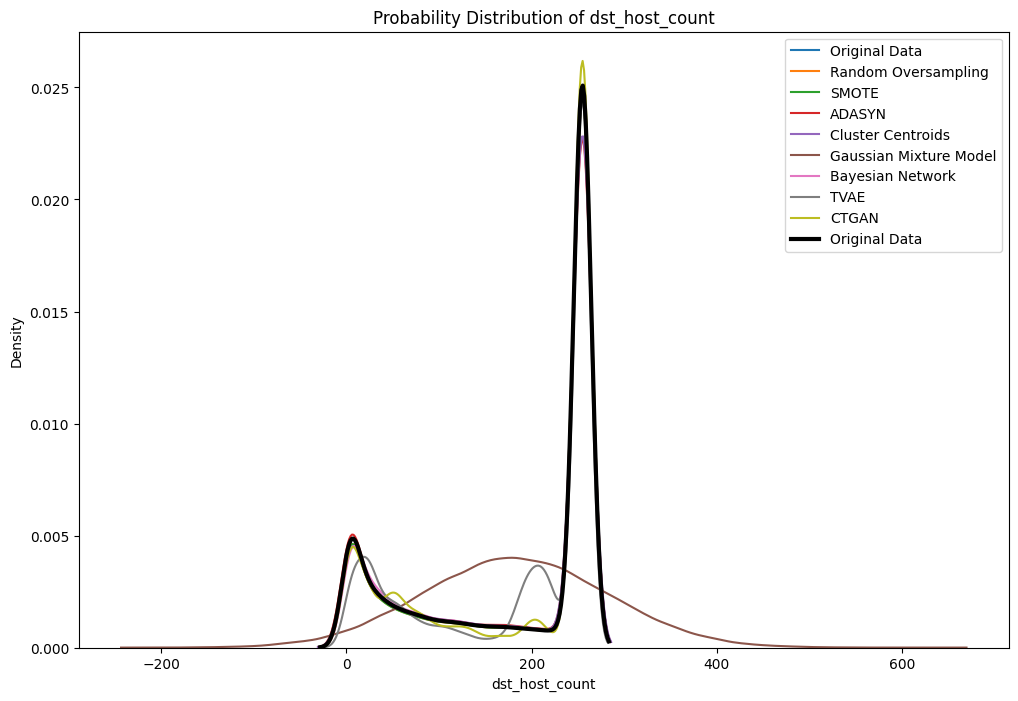

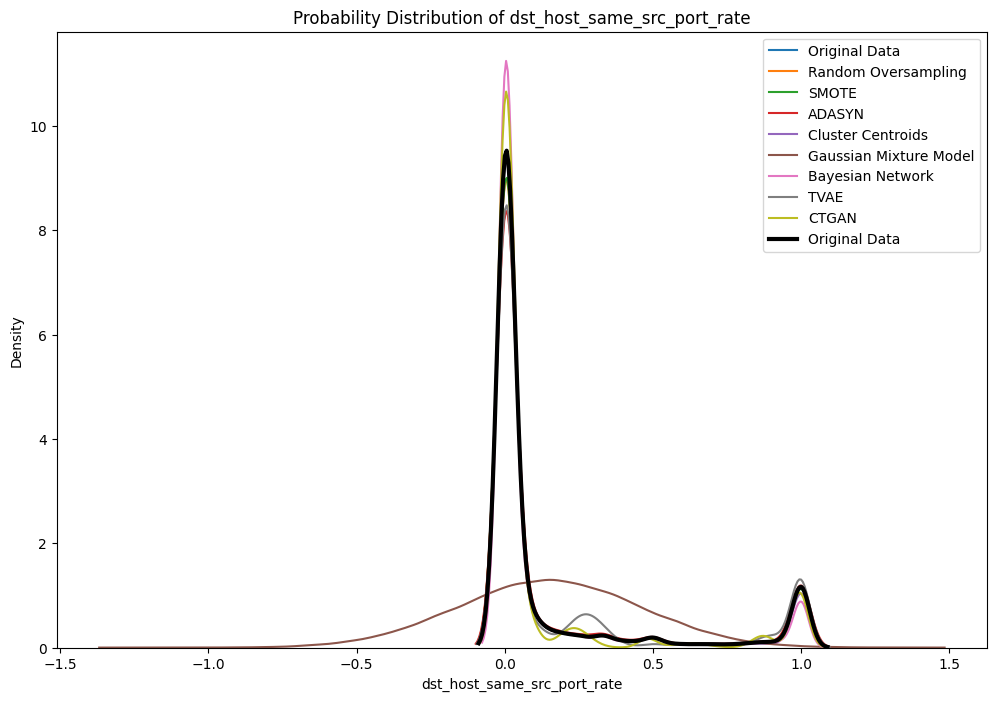

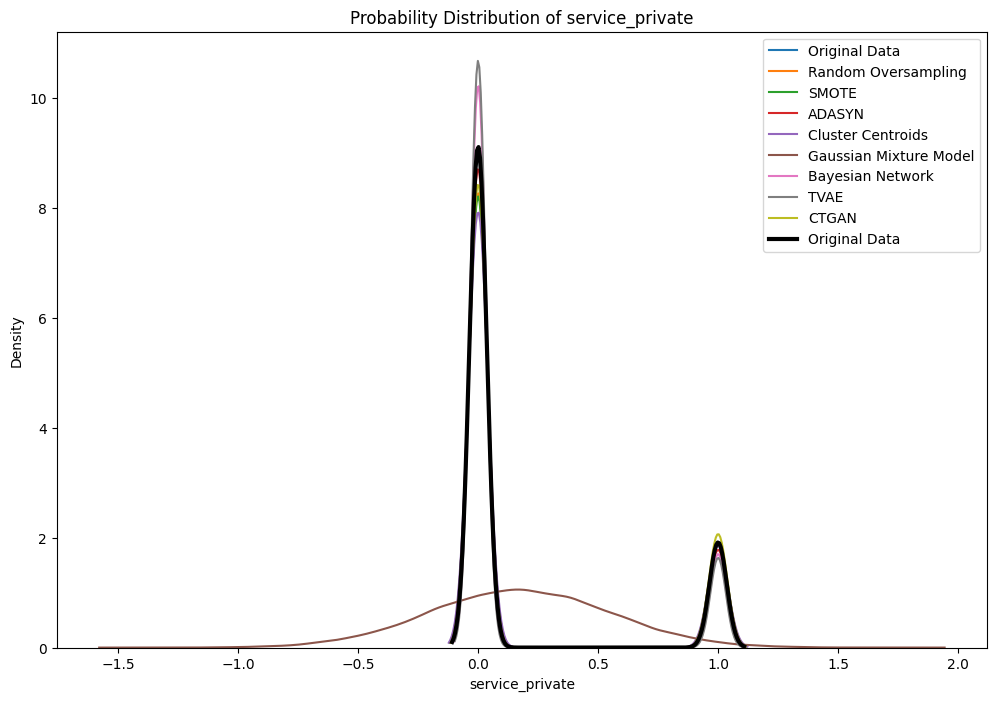

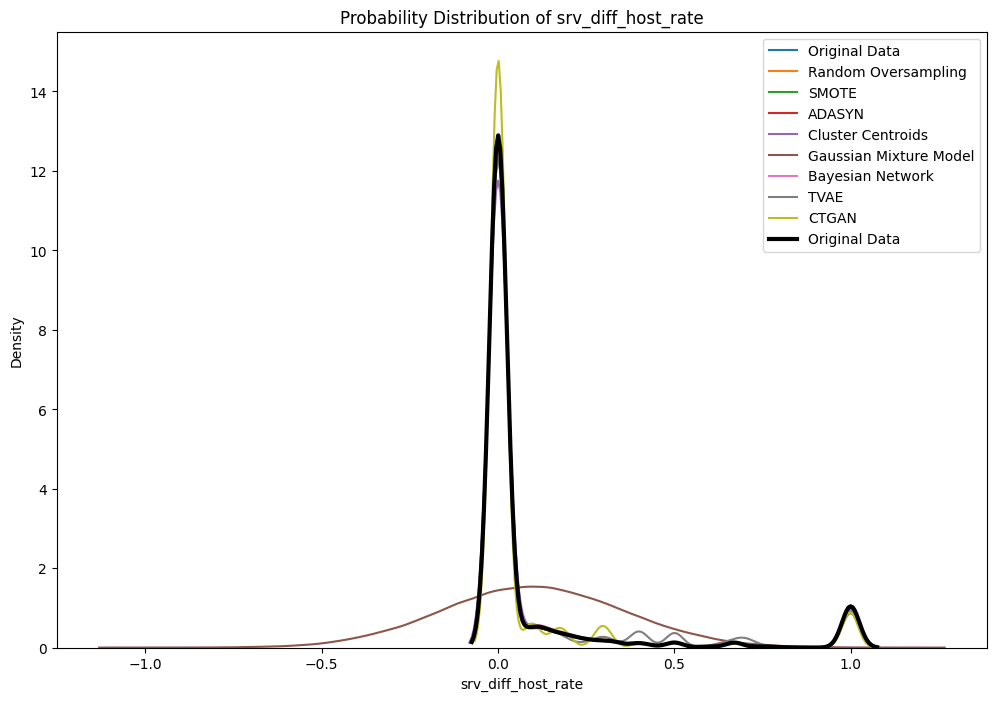

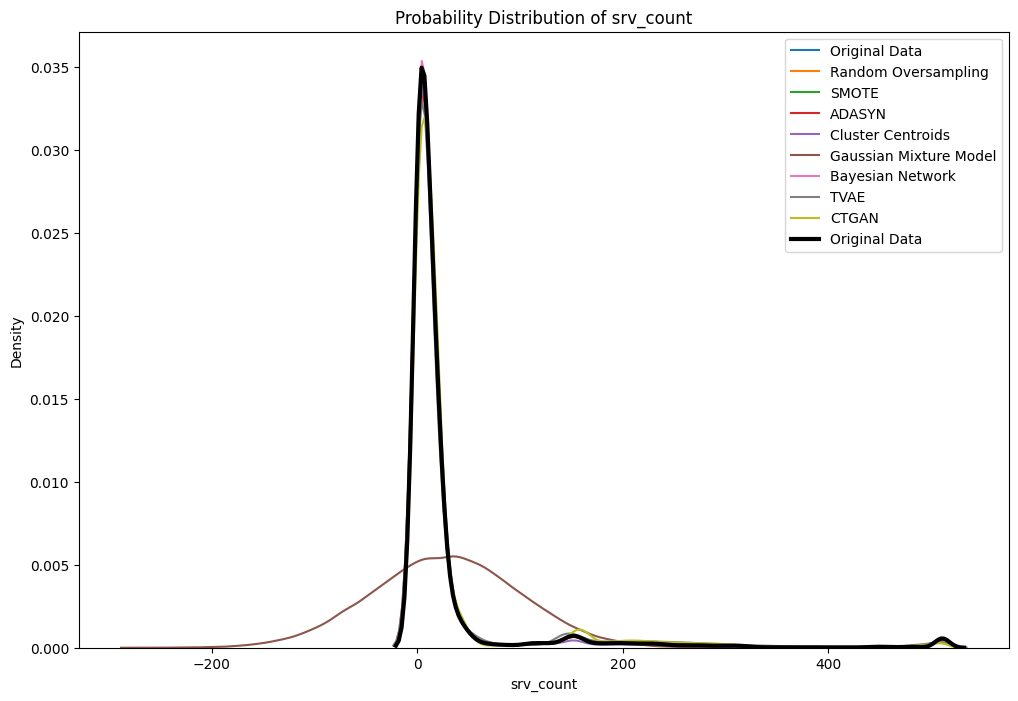

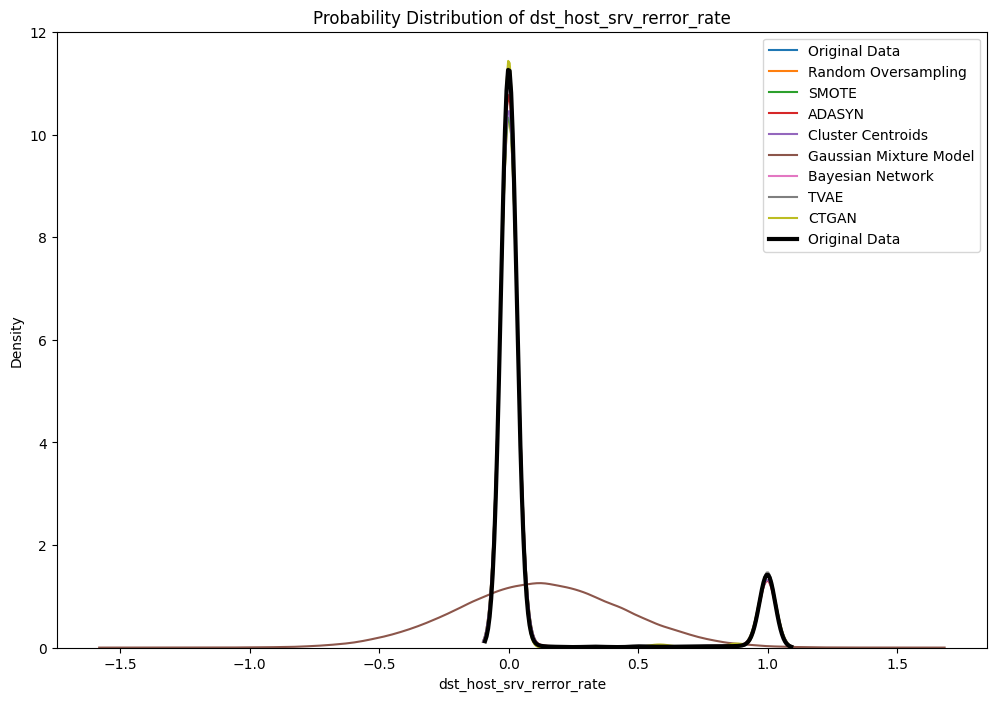

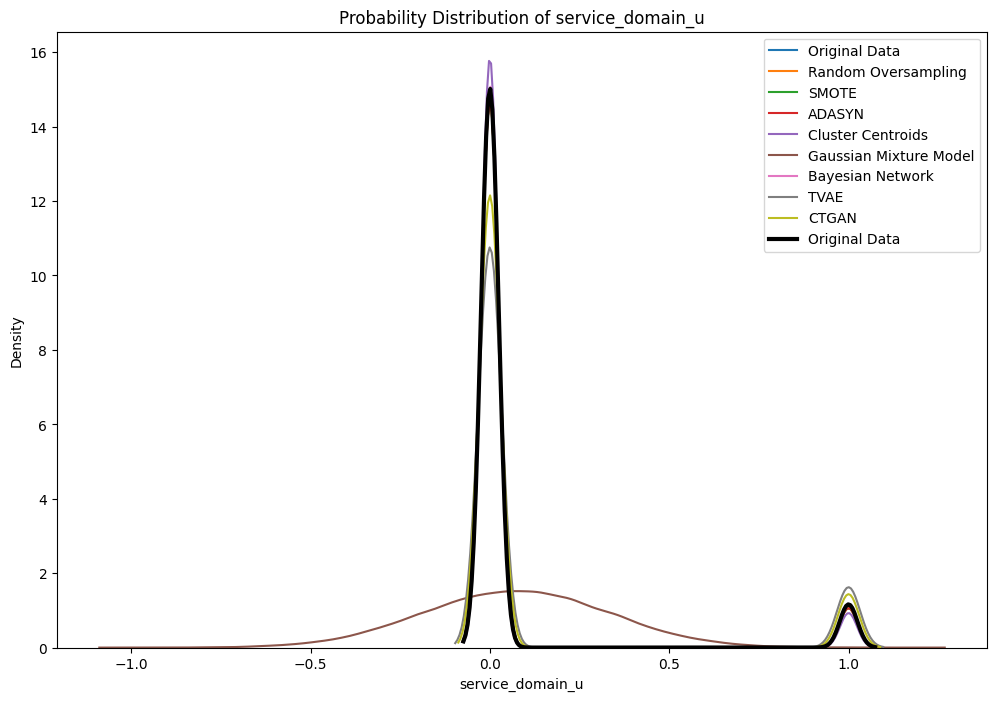

In [19]:

# List of DataFrames
dfs = [data, df_ros, df_smote, df_adasyn, df_cc, df_gmm, df_bn, df_tvae, df_ctgan]
titles = ["Original Data", "Random Oversampling", "SMOTE", "ADASYN", "Cluster Centroids", 
          "Gaussian Mixture Model", "Bayesian Network", "TVAE", "CTGAN"]

# Function to compare distributions and calculate KS test results
def compare_distributions(real_data, synthetic_datasets, titles):
    results = {}
    average_results = {}
    
    for synthetic_data, title in zip(synthetic_datasets, titles):
        
        ks_results = []
        
        equal_count = 0
        different_count = 0
        
        for column in real_data.columns:
            if column == 'target':
                continue
            
            real_values = real_data[column].values
            synthetic_values = synthetic_data[column].values
            
            # Perform KS Test
            ks_statistic, ks_p_value = ks_2samp(real_values, synthetic_values)
            
            # Store KS test results
            ks_results.append({
                'Feature': column,
                'KS Statistic': ks_statistic,
                'KS P-value': ks_p_value
            })
            
            # Count equal and different distributions
            if ks_p_value > 0.05:
                equal_count += 1
            else:
                different_count += 1
        
        # Store results for current synthetic dataset
        results[title] = ks_results
        
        # Calculate average results
        total_features = len(real_data.columns) - 1  # excluding target column
        average_results[title] = {
            'Equal Distributions': equal_count,
            'Different Distributions': different_count,
            'Average KS P-value': np.mean([result['KS P-value'] for result in ks_results])
        }
    
    # Print average results
    print("\n--- Average Results ---")
    for title, avg_res in average_results.items():
        print(f"{title}:")
        print(f"Equal Distributions: {avg_res['Equal Distributions']}")
        print(f"Different Distributions: {avg_res['Different Distributions']}")
        print(f"Average KS P-value: {avg_res['Average KS P-value']}")
        print("-----------------------------")
    
    return results, average_results

# Function to plot KDE plots for all features across all datasets
def plot_kde_comparison(real_data, synthetic_datasets, titles, ks_results):
    num_datasets = len(synthetic_datasets) + 1  # including original data
    num_features = len(real_data.columns) - 1  # excluding target column
    
    for column in real_data.columns:
        if column == 'target':
            continue
        
        plt.figure(figsize=(12, 8))
        for i, synthetic_data in enumerate(synthetic_datasets):
            sns.kdeplot(synthetic_data[column], label=titles[i])
        
        sns.kdeplot(real_data[column], label='Original Data', linewidth=3, color='black')
        
        # Annotate KS test results on the plot
        #for result in ks_results:
         #   ks_statistic = result['KS Statistic']
          #  ks_p_value = result['KS P-value']
           # if ks_p_value > 0.05:
            #    plt.text(0.98, 0.95 - ks_results.index(result)*0.05, f'{result["Feature"]}: KS p-value={ks_p_value:.3f}', transform=plt.gca().transAxes, ha='right', color='green')
            #else:
             #   plt.text(0.98, 0.95 - ks_results.index(result)*0.05, f'{result["Feature"]}: KS p-value={ks_p_value:.3f}', transform=plt.gca().transAxes, ha='right', color='red')
        
        plt.title(f'Probability Distribution of {column}')
        plt.legend()
        plt.show()

# Example usage
# Assuming `dfs`, `titles`, and `df` are defined as before
results, average_results = compare_distributions(data, dfs, titles)
plot_kde_comparison(data, dfs, titles, results[titles[1]])  # Display for one synthetic dataset (change index as needed)


In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1

# Initialize results dictionary
utility_results = {title: {'TRTR_accuracy': 0, 'TRTR_f1': 0, 'TSTR_accuracy': 0, 'TSTR_f1': 0} for title in titles[1:]}

# Reindex X_train and X_test to ensure consistent feature order
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

# Evaluate TRTR (Training on Real, Testing on Real)
model_trtr = RandomForestClassifier(random_state=42)
model_trtr.fit(X_train, y_train)
trtr_accuracy, trtr_f1 = evaluate_model(model_trtr, X_test, y_test)
utility_results["Original Data"] = {'TRTR_accuracy': trtr_accuracy, 'TRTR_f1': trtr_f1}

# Evaluate TSTR (Training on Synthetic, Testing on Real)
for i, data in enumerate(dfs[1:], 1):
    X_synthetic = data.drop('target', axis=1)
    y_synthetic = data['target']
    
    # Reindex X_synthetic to match the order of X_test
    X_synthetic = X_synthetic.reindex(columns=X_test.columns)

    model_tstr = RandomForestClassifier(random_state=42)
    model_tstr.fit(X_synthetic, y_synthetic)
    tstr_accuracy, tstr_f1 = evaluate_model(model_tstr, X_test, y_test)
    utility_results[titles[i]]['TSTR_accuracy'] = tstr_accuracy
    utility_results[titles[i]]['TSTR_f1'] = tstr_f1

# Display the utility results
utility_df = pd.DataFrame(utility_results).T
print("Utility results (F1 score, accuracy comparison of TRTR and TSTR) for all datasets:")
print(utility_df)


Utility results (F1 score, accuracy comparison of TRTR and TSTR) for all datasets:
                        TRTR_accuracy   TRTR_f1  TSTR_accuracy   TSTR_f1
Random Oversampling          0.000000  0.000000       0.999286  0.999286
SMOTE                        0.000000  0.000000       0.999391  0.999391
ADASYN                       0.000000  0.000000       0.999206  0.999206
Cluster Centroids            0.000000  0.000000       0.999391  0.999391
Gaussian Mixture Model       0.000000  0.000000       0.534584  0.372453
Bayesian Network             0.000000  0.000000       0.958536  0.958388
TVAE                         0.000000  0.000000       0.981769  0.981767
CTGAN                        0.000000  0.000000       0.965972  0.965935
Original Data                0.999259  0.999259            NaN       NaN


In [24]:
data.columns

Index(['src_bytes', 'dst_bytes', 'same_srv_rate', 'diff_srv_rate', 'flag_SF',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'logged_in',
       'dst_host_serror_rate', 'dst_host_diff_srv_rate',
       'dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate', 'flag_S0',
       'count', 'service_http', 'dst_host_srv_diff_host_rate', 'level',
       'dst_host_count', 'dst_host_same_src_port_rate', 'service_private',
       'srv_diff_host_rate', 'srv_count', 'dst_host_srv_rerror_rate',
       'service_domain_u', 'target'],
      dtype='object')

In [25]:
dfs = [data, df_ros, df_smote, df_adasyn, df_cc, df_gmm, df_bn, df_tvae, df_ctgan]
titles = ["Original Data", "Random Oversampling", "SMOTE", "ADASYN", "Cluster Centroids", 
          "Gaussian Mixture Model", "Bayesian Network", "TVAE", "CTGAN"]

for title, df in zip(titles, dfs):
    print(f"DataFrame: {title}")
    print(df.logged_in.value_counts())
    #print(df.protocol_type_icmp.value_counts())
    #print(df.protocol_type_tcp.value_counts())
    print(df.service_http.value_counts())
    print(df.flag_S0.value_counts())
    print(df.service_private.value_counts())
    print(df.target.value_counts())
    print("\n")  # Add a newline for better readability between DataFrames


DataFrame: Original Data
logged_in
0    59278
1    35002
Name: count, dtype: int64
service_http
False    65806
True     28474
Name: count, dtype: int64
flag_S0
False    66338
True     27942
Name: count, dtype: int64
service_private
False    76820
True     17460
Name: count, dtype: int64
target
1    47140
0    47140
Name: count, dtype: int64


DataFrame: Random Oversampling
logged_in
0    59278
1    35002
Name: count, dtype: int64
service_http
False    65806
True     28474
Name: count, dtype: int64
flag_S0
False    66338
True     27942
Name: count, dtype: int64
service_private
False    76820
True     17460
Name: count, dtype: int64
target
1    47140
0    47140
Name: count, dtype: int64


DataFrame: SMOTE
logged_in
0    59270
1    35010
Name: count, dtype: int64
service_http
False    65734
True     28546
Name: count, dtype: int64
flag_S0
False    66187
True     28093
Name: count, dtype: int64
service_private
False    76624
True     17656
Name: count, dtype: int64
target
1    47140
0    4